## Data for Learning to Speak and Act in a Fantasy Text Adventure Game


Facebook AI Research released a dataset for their paper [Learning to Speak and Act in a Fantasy Text Adventure Game](https://aclanthology.org/D19-1062/).

Their data is called the LIGHT dataset (Learning in Interactive Games with Humans and Text).  It contains 663 locations, 3462 objects and 1755 characters.  We have divided this data into training/dev/test splits.


## Load the data

The LIGHT data was released as part of the Facebook's ParlAI system. I extracted the data into several JSON files:
* ```light_environment_train.json``` contains information about the locations, objects, and characters in the text-adventure games.  
* ```light_dialogue_data.json``` contains sample conversations between pairs of characters.   We'll use this later in the semester.



In [ ]:
!wget https://raw.githubusercontent.com/interactive-fiction-class/interactive-fiction-class-data/master/light_dialogue/light_environment_train.json

--2024-09-17 00:06:27--  https://raw.githubusercontent.com/interactive-fiction-class/interactive-fiction-class-data/master/light_dialogue/light_environment_train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3541467 (3.4M) [text/plain]
Saving to: ‘light_environment_train.json’

light_environment_t 100%[===================>]   3.38M  --.-KB/s    in 0.08s   

2024-09-17 00:06:27 (42.9 MB/s) - ‘light_environment_train.json’ saved [3541467/3541467]



In [ ]:
import sys
import os
import json

json_filename = 'light_environment_train.json'

f = open(json_filename)
light_environment = json.load(f)


# LIGHT Environment Data

This section of the Python Notebook will walk you through the LIGHT environment data to show you the different elements of the JSON file.  We will use different pieces of these to fine-tune GPT3 in order to generate new locations and objects for our own text adventure games.


### Categories

The locations in LIGHT environment are grouped by categories.

```
categories =  light_environment['categories']

categories

 {'11': 'Graveyard',
 '12': 'Wasteland',
 '13': 'Abandoned',
 '14': 'Mountain',
 '15': 'Cave',
 '16': 'Tavern',
 '17': 'Jungle',
 '18': 'Trail',
 '19': 'Town',
 '2': 'Forest',
 '20': 'Dungeon',
 '21': 'Inside Cottage',
 ... }
```


I split the LIGHT environment data into training/dev/test splits based on cateogries.  Here are the categories that ended up in the training partition.

In [ ]:
def get_categories(light_environment):
  return light_environment['categories'].values()
categories = get_categories(light_environment)

print("\n".join(categories))

Forest
Shore
Countryside
Port
Swamp
Lake
Graveyard
Abandoned
Cave
Trail
Dungeon
Outside Cottage
Inside Castle
Outside Castle
Inside Church
Outside Church
Inside Temple
Outside Temple
Inside Tower
Outside Tower
Inside Palace
Outside Palace
Farm
city in the clouds
magical realm
netherworld
supernatural
underwater aquapolis



### Rooms

In text-adventure games, locations or settings are often called "rooms".  Rooms have a primary description of the location, a secondary description of the location with its background information, connections to neighboring rooms, and they can contain objects or non-player characters.

Here's what the data structure looks like for a particular room in LIGHT (room number 62, 'An Unfinished Mausoleum', part of the 'Graveyard' category.

```
rooms = light_environment['rooms']
rooms['62']

{'background': "Bright white stone was all the fad for funerary architecture, once upon a time. It's difficult to understand why someone would abandon such a large and expensive undertaking. If they didn't have the money to finish it, they could have sold the stone, surely - or the mausoleum itself. Maybe they just haven't needed it yet? A bit odd, though, given how old it is. Maybe the gravedigger remembers... if he's sober.",
 'category': 'Graveyard',
 'description': 'Two-and-a-half walls of the finest, whitest stone stand here, weathered by the passing of countless seasons. There is no roof, nor sign that there ever was one. All indications are that the work was abruptly abandoned. There is no door, nor markings on the walls. Nor is there any indication that any coffin has ever lain here... yet.',
 'ex_characters': [204, 75, 156, 720],
 'ex_objects': [1791, 1792, 439],
 'in_characters': [203, 203],
 'in_objects': [1790],
 'neighbors': [108, 109],
 'room_id': 62,
 'setting': 'An Unfinished Mausoleum'}
```

The **in_objects** and **in_characters** are people and things that are explictly mentioned  listed in the description or the backstory.  The **ex_characters** and **ex_objects** are objects that are possibly present but not mentioned directly. These characters and objects are referenced by a numeric ID which are stored in a seperate part of the LIGHT environment file.



Here are the rooms that are in the 'Graveyard' category.

In [ ]:
from collections import defaultdict

rooms_by_id = light_environment['rooms']

rooms_by_category = defaultdict(set)
for room_id in rooms_by_id:
  category = light_environment['rooms'][room_id]['category']
  rooms_by_category[category].add(room_id)

def get_room_name(room_id, rooms_by_id=rooms_by_id):
  return rooms_by_id[room_id]['setting']

def print_rooms_for_category(category, rooms_by_category, rooms_by_id):
  rooms = rooms_by_category[category]
  print(category.capitalize())
  for room_id in rooms:
    print('\t', room_id, '-', get_room_name(room_id))

print_rooms_for_category('Graveyard', rooms_by_category, rooms_by_id)



Graveyard
	 62 - An Unfinished Mausoleum
	 162 - Reception area
	 340 - A cursed grave
	 100 - Old Crypt
	 702 - Main street
	 277 - Graveyard
	 158 - the fountain
	 431 - Abandoned workers shed
	 144 - Cemetery
	 386 - Tombstones of the Kings
	 661 - Main graveyard
	 462 - Dead Tree


### Neighbors

Rooms are connected to other rooms.  The LIGHT dataset stores the connections in a variable called ```light_environment['neighbors']```.  Here is an example of what is information is stored about these connections.

```
 '108': {'connection': 'walking carefully between fallen headstones',
  'destination': 'Fresh Grave',
  'direction': 'West',
  'inverse_id': None,
  'room_id': 62},
 '109': {'connection': 'following a dirt trail behind the mausoleum',
  'destination': 'Dead Tree',
  'direction': 'South',
  'inverse_id': None,
  'room_id': 62},
```

These can be thought of as arcs in a directed graph, where the rooms are nodes, and these elements are the arcs that connect a pair of nodes.  The head of the arc (the ***to node***) is specified by the ```destination``` field (a description rather than an ID), and tail of the arc (the ***from node***) is specified by the ```room_id```.

In [ ]:
arcs = light_environment['neighbors']

# Create a dictionary that maps room names ('setting') to IDs
room_names_to_id = {room['setting']:room_id for (room_id,room) in rooms_by_id.items()}


def make_connections(arcs):
#  direction, connected_location, travel_description
  for arc_id, arc in arcs.items():
    try:
      source_id = str(arc['room_id'])
      target_id = str(room_names_to_id[arc['destination']])
      direction = arc['direction']
      travel_description = arc['connection']
      source_name = get_room_name(source_id)
      target_name = get_room_name(target_id)
      # Print out the room connections in the Graveyard
      if source_id in rooms_by_category['Graveyard']:
        print('====')
        print(source_name, '-->', target_name)
        print(direction)
        print(travel_description)
    except:
      pass

make_connections(arcs)

====
An Unfinished Mausoleum --> Dead Tree
South
following a dirt trail behind the mausoleum
====
Old Crypt --> Abandoned workers shed
South
walking down the cobbled path
====
Cemetery --> Main street
West
following the cobblestone path
====
Reception area --> Main graveyard
East
walking
====
Tombstones of the Kings --> Church
North
exiting the graveyard
====
Abandoned workers shed --> Old Crypt
North
walking down the cobbled path
====
Main street --> Cemetery
South
traveling the road south
====
Main street --> Cemetery
East
following the cobblestone path



### Characters


Characters have a description, a persona (a first person description of who they are and what their motivations might be), a character type (person, creature or object), a location (```in_room_id```) and an an inventory (```carrying_objects```)

The Gravedigger character is listed in the Unfinished Mausoleum's ``in_characters`` variable.  The ``in_characters`` are characters that are explictly mentioned in the location's ``description`` or ``background`` variables.  In this case, the Gravedigger is mentioned in the Unfinished Mausoleum's ``background`` variable.
```
light_environment['characters']['203']

{'base_form': ['gravedigger'],
 'carrying_objects': [890],
 'char_type': 'person',
 'character_id': 203,
 'corrected_name': 'gravedigger',
 'desc': 'You might want to talk to the gravedigger, specially if your looking for a friend, he might be odd but you will find a friend in him.',
 'ex_room_ids': [100, 349],
 'in_room_ids': [62],
 'is_plural': 0,
 'name': 'gravedigger',
 'orig_room_id': 349,
 'personas': ["I am low paid labor in this town. I do a job that many people shun because of my contact with death. I am very lonely and wish I had someone to talk to who isn't dead."],
 'wearing_objects': [],
 'wielding_objects': []}

 ```
 Here are the ``ex_characters`` from the Unfinished Mausoleum.  They are not explicitly mentioned in the room's description or background, but the annotators thought that these characters were the kinds of characters that might be found there.

```
for id in "204, 75, 156, 720".split(','):
  print(light_environment['characters'][id.strip()]['corrected_name'])

thief
peasant
mouse
bat
```


In [ ]:
for id in "204, 75, 156, 720".split(','):
  print(light_environment['characters'][id.strip()]['corrected_name'])

thief
peasant
mouse
bat


Here is the Gravedigger character.  Characters have descriptions, name, and personas.  We'll use personas later in the semester when we look at generating dialogue for characters.

In [ ]:
light_environment['characters']['203']

{'base_form': ['gravedigger'],
 'corrected_name': 'gravedigger',
 'personas': ["I am low paid labor in this town. I do a job that many people shun because of my contact with death. I am very lonely and wish I had someone to talk to who isn't dead."],
 'character_id': 203,
 'in_room_ids': [62],
 'ex_room_ids': [100, 349],
 'name': 'gravedigger',
 'is_plural': 0,
 'char_type': 'person',
 'orig_room_id': 349,
 'carrying_objects': [890],
 'wearing_objects': [],
 'wielding_objects': [],
 'desc': 'You might want to talk to the gravedigger, specially if your looking for a friend, he might be odd but you will find a friend in him.'}

In [ ]:
characters_by_id = light_environment['characters']
characters_by_id['203']

from collections import Counter

def count_character_types(characters_by_id):
  character_types = Counter()
  for character_id in characters_by_id:
    character = characters_by_id[character_id]
    char_type = character['char_type']
    character_types[char_type] += 1
  return character_types

character_types = count_character_types(characters_by_id)
print(character_types)


Counter({'person': 1028, 'creature': 304, 'object': 38})


### Objects

Objects are inanimate things in the game.  They have descriptions, locations, and a set of properties that could be used to govern how a player interacts with them.  The properties of objects in the light dataset are
* is_container
* is_drink
* is_food
* is_gettable
* is_plural
* is_surface
* is_weapon
* is_wearable

These properties have numeric values associated with them.  The values seem to be something like 0.0 = false, 1.0 = true, 0.5 = possibly.

Here is an example object:
```
light_environment['objects']['1188']

 {'base_form': ['sword', 'Sword'],
 'desc_entries': 2,
 'descriptions': ['The sword is very old, you would assume it had once belonged to a legendary warrior.',
  "The sword's legend is known by everyone, it is famous throughout the land."],
 'ex_room_ids': [],
 'holding_character_ids': [],
 'in_room_ids': [12],
 'is_container': 0.0,
 'is_drink': 0.0,
 'is_food': 0.0,
 'is_gettable': 1.0,
 'is_plural': 1.0,
 'is_surface': 0.0,
 'is_weapon': 1.0,
 'is_wearable': 0.0,
 'link_entries': 1,
 'name': 'Legendary swords',
 'object_id': 1188}
 ```

In [ ]:
light_environment['objects']['1188']

{'base_form': ['sword', 'Sword'],
 'descriptions': ['The sword is very old, you would assume it had once belonged to a legendary warrior.',
  "The sword's legend is known by everyone, it is famous throughout the land."],
 'is_container': 0.0,
 'is_drink': 0.0,
 'is_food': 0.0,
 'is_gettable': 1.0,
 'is_surface': 0.0,
 'is_wearable': 0.0,
 'is_weapon': 1.0,
 'object_id': 1188,
 'desc_entries': 2,
 'link_entries': 1,
 'is_plural': 1.0,
 'in_room_ids': [12],
 'ex_room_ids': [],
 'name': 'Legendary swords',
 'holding_character_ids': []}

In [ ]:
obj = light_environment['objects']['1188']
print(obj['name'])
print(obj['object_id'])
for label, value in obj.items():
  if label.startswith('is_') and value == 1.0:
    print(label, value)

Legendary swords
1188
is_gettable 1.0
is_weapon 1.0
is_plural 1.0


In [ ]:
objects_by_id = light_environment['objects']

def sort_objects_by_property(objects_by_id):
  objects_by_property = defaultdict(set)
  for object_id, obj in objects_by_id.items():
    name = obj['name']
    for label, value in obj.items():
      if label.startswith('is_') and value == 1:
        objects_by_property[label].add(object_id)
  return objects_by_property

objects_by_property = sort_objects_by_property(objects_by_id)

# print 20 objects for each property
for prop in objects_by_property:
  print(prop)
  for counter, object_id in enumerate(objects_by_property[prop]):
    if counter < 20:
      obj_name = objects_by_id[object_id]['name']
      print('\t', obj_name)


is_gettable
	 chains
	 specks of dust
	 bedding
	 hooks
	 a dim lamp
	 giant club
	 journal
	 a broken lantern
	 quilts
	 gift
	 gold hair
	 Clothes
	 lush green vegetation
	 plate
	 cauldron
	 seeds
	 sorcerer's orb
	 detailed paintings
	 precious stones
	 sapphire
is_plural
	 chains
	 specks of dust
	 hooks
	 rivets
	 paper records
	 stalls
	 seeds
	 fancy dinners
	 Life Buoys
	 detailed paintings
	 meadows
	 bulbs
	 precious stones
	 life vests
	 worms
	 some illustrations in a book
	 several pairs of manacles
	 racks
	 wheelbarrows
	 ancient religious texts
is_weapon
	 chains
	 spikes
	 nails
	 stone
	 specks of dust
	 flail
	 hooks
	 decorative swords
	 Ivory spikes
	 giant club
	 staff
	 Pirate swords
	 bow
	 axes
	 prayer books
	 garden bench
	 gift
	 plate
	 Crosses
	 torture implements
is_surface
	 beach
	 broken chairs
	 bedding
	 place mats
	 Animal skins used as rugs
	 food tray
	 handmade rug
	 Ivory spikes
	 a small pool of water
	 normal benches
	 rivets
	 round stone ta

# Format Data for Fine-Tuning

Below, I show how to create data to fine-tune OpenAI.  The OpenAI API documentation has a [guide to fine-tuning models](https://beta.openai.com/docs/guides/fine-tuning) that you should read.   The basic format of fine-tuning data is a JSONL file (one JSON object per line) with two key-value pairs: `prompt:` and `completion:`.

```
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
{"prompt": "<prompt text>", "completion": "<ideal generated text>"}
...
```

In the code below, I'll extract a prompt that contains the `Category` and `Setting` variables from a LIGHT Environment room, and I'll have the completion be the room's `Description`.

In [ ]:

def get_room_description(room_id, rooms_by_id, light_environment):
  """
  This generates a prompt and a completion which can be used to fine-tune OpenAI.
  This version just gnnerates
  """
  prompt = ""
  completion = ""
  prompt += "Category: {category}\n".format(category=rooms_by_id[room_id]['category'].capitalize())
  prompt += "Setting: {setting}\n".format(setting=rooms_by_id[room_id]['setting'].capitalize())
  completion += "Description: {description}\n".format(description=rooms_by_id[room_id]['description'])
  completion += "###\n"

  return prompt, completion


def create_location_finetuning_data(filename='fine_tuning_location_descriptions.jsonl'):
  fine_tuning_data = []
  for category in categories:
    rooms = rooms_by_category[category]
    for room_id in rooms:
      data = {}
      prompt, completion = get_room_description(room_id, rooms_by_id, light_environment)
      data['prompt'] = prompt
      data['completion'] = completion
      print(prompt, end="")
      print(completion)
      fine_tuning_data.append(data)

  with open(filename, 'w') as out:
    for data in fine_tuning_data:
        out.write(json.dumps(data))
        out.write('\n')

create_location_finetuning_data()

Category: Forest
Setting: Flower garden
Description: This clearing is in reveal a wide circle of trees. Proud oaks stand close enough that only the smallest of fauna can squeeze through, protecting the garden within from curious deer and hungry rabbits. Flowers of every hue and shade crowd the soft lawn of grass, soaking up what light they can through the shadows cast by the branches above. Purple, yellow, red, blue - even green blossoms bob in the breeze, their scents mixing to create a heady perfume. Vines and creepers climb up the tree trunks, dripping with grapes and berries.
###

Category: Forest
Setting: Unsettling forest area
Description: The forest is actually very creepy even during the day. The trees are so tall that they block the sunlight. There is always fog in the forest which makes it very hard to see. There are a lot of mushrooms near the trees and none of them are edible
###

Category: Forest
Setting: Entrance to the pine trees
Description: Very tall and towering pine 

# Fine-tune GPT3 with the OpenAI API

Next, we'll perform fine-tuning with this data using OpenAI.

In [ ]:
%%capture
!pip install --upgrade openai
!pip install jsonlines

Once you've got access to the OpenAI API, you can find your OpenAI API key [here](https://platform.openai.com/api-keys).

In [ ]:
import os
import openai

print('Enter OpenAI API key:')
openai.api_key = input()

os.environ['OPENAI_API_KEY']=openai.api_key

In [ ]:
!head fine_tuning_location_descriptions.jsonl

{"prompt": "Category: Forest\nSetting: Pine tree graveyard\n", "completion": "Description: Once known as a forest of solitude, the entrance to the pine trees is now a bleak and dreary graveyard.  Dead grass and moss fill the ground along with crawling critters that mark fear in the mind among the he who venture here.  Tombstones so old many of the names are no longer eligible.  Dense fog surrounds the area, thick tree tops blotting out the sunlight, and an eerie silence fills the air.  Cold it feels, the air, but the ground is soft and warm.  Sound can not enter, no escape this dwelling.\n###\n"}
{"prompt": "Category: Forest\nSetting: A wooded magical village\n", "completion": "Description: The village lay hidden in a secret grotto that is set in a sort of valley between trees. The village is populated by child-like peoples who wear clothes made of various plant matter such as large leaves and vines. The homes are made of wood, and seemingly blend into the green dense backdrop.\n###\n"

Next, we'll make the fine tuning API call via the command line using an older GPT model.  Here the -m argument gives the model.  

The early GPT-3 models had 4 sizes, in alphabetical order from smallest to largest:
* Ada
* Babbage
* Currie
* Davinci

Since then, OpenAI has collapsed these early models into `babbage-002` and `davinci-002`. There is also `gpt-3.5-turbo`, `gpt-4o-mini-2024-07-18`, and `gpt-4o-2024-08-06` available for fine-tuning.

The bigger the model that you fine-tune, the more expensive it is going to be to train. You can find more about the pricing of fine-tuning models here: https://openai.com/api/pricing/


Here, we will fine-tune babbage. But first we need the prep the data:

In [ ]:
client = openai.OpenAI()

client.files.create(
    file=open("fine_tuning_location_descriptions.jsonl",'rb'),
    purpose="fine-tune"
)

Copy the "id" from the FileObject above and paste it into the input box below:

In [ ]:
print('Training File ID:')
training_file = input()

Run the fine-tuning:

In [ ]:
client.fine_tuning.jobs.create(
  training_file=training_file,
  model="babbage-002"
)

You should copy down the fine-tune id. For example, from this output:

```
FineTuningJob(id='ftjob-yOdB7l1G9tmxmcSyVNxf4p0g', created_at=1726532773, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='babbage-002', object='fine_tuning.job', organization_id='org-vMIh6r7dmxgLkwGhsJvsTlbH', result_files=[], seed=1164052202, status='validating_files', trained_tokens=None, training_file='file-cXW5UO9CQupbTneczqQj9fyE', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)
```

Fine-tune id:
```
ftjob-yOdB7l1G9tmxmcSyVNxf4p0g
```


If you forget to write it down, you can list your fine-tuned runs and models this way. These model names aren't mneumonic, so it is probably a good idea to make a note on what your model's inputs and outputs are.

In [ ]:
!curl https://api.openai.com/v1/fine_tuning/jobs?limit=2 \
  -H "Authorization: Bearer $OPENAI_API_KEY"

You can also run your fine-tuned model in the OpenAI Playground once it is done training.  

You'll need to provide the model a prompt that matches our training data.  In this case we gave it a `Category:` and a `Location:` name.  You can also add the `Description:` part of the completion if you want. You should also set the stop sequence to be `###`. For example, we could type this input into the playground:

```
Category: Dark Forest
Location: Winter's Glade
Description:
```
If you press the "Generate" then your fine-tuned model will output something like:

> The forest at night is not a place one would willingly set foot in. It is cold and dark and seems to go on forever. Trees loom over you, blocking out the light of the moon and stars. The only sound is the occasional howl of a wolf and the occasional splashing of water.




In [ ]:
def get_location_description(category, location_name, finetuned_model):
  response = client.completions.create(
      model=finetuned_model,
      prompt="Category: {category}\nLocation: {location}\nDescription:".format(
          category=category.capitalize(),
          location=location_name.capitalize()
      ),
      temperature=0.7,
      max_tokens=64,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
      stop=["###"]
      )
  return response.choices[0].text

# Replace with your model's name
finetuned_model = "ft:babbage-002:lara-lab-umbc::A8GViIPp"
category = "Dark Forest"
location_name = "Winter's Glade"

description = get_location_description(category, location_name, finetuned_model)
print(description)

 The dark glade is a place of deep dark shadows and unfamiliar shapes. tall trees loom overhead, dark and mysterious. many wild animals call this place home and they quickly scare away any human that dares to venture here.



# TODO: Fine-Tune Additional Models for Text Adventure Games

In this assignment, we'll ask you to fine-tune models to perform the following tasks:
1. Describe a location (I've given you this code.  You can adapt it for other model.)
- inputs: category, location name
- output: location description
2. Get an item's properties
- inputs: item name, item description, property (e.g. gettable)
- output: True or False if the item has that property


In [ ]:
# Setup the training data
def create_item_finetuning_data(filename='fine_tuning_item_properties.jsonl'):
  #TODO
  pass

In [ ]:
# Finetune the model

#TODO

In [ ]:
# Call the model

def get_item_property(property_name, item_name, item_description, finetuned_model, property_description=""):
  if property_name == "is_gettable":
    return is_gettable(item_name, item_description, finetuned_model)
  elif property_name == "is_weapon":
    return is_weapon(item_name, item_description, finetuned_model)
  elif property_name == "is_surface":
    return is_surface(item_name, item_description, finetuned_model)
  elif property_name == "is_container":
    return is_container(item_name, item_description, finetuned_model)
  elif property_name == "is_wearable":
    return is_wearable(item_name, item_description, finetuned_model)
  elif property_name == "is_drink":
    return is_drink(item_name, item_description, finetuned_model)
  elif property_name == "is_food":
    return is_food(item_name, item_description, finetuned_model)
  else:
    pass

def is_gettable(item_name, item_description, finetuned_model, property_description="A player can pick this item up and add it to their inventory."):
  #TODO
  pass

def is_weapon(item_name, item_description, finetuned_model, property_description="This item can be used as a weapon."):
  #TODO
  pass

def is_surface(item_name, item_description, finetuned_model, property_description="Another item can be placed on top of this item."):
  #TODO
  pass

def is_container(item_name, item_description, finetuned_model, property_description="Other items can be stored inside of this item."):
  #TODO
  pass

def is_wearable(item_name, item_description, finetuned_model, property_description="This item can be worn as an item of cloting."):
  #TODO
  pass

def is_drink(item_name, item_description, finetuned_model, property_description="This item is a liquid that can be drunk."):
  #TODO
  pass

def is_food(item_name, item_description, finetuned_model, property_description="This item can be eaten."):
  #TODO
  pass

# TODO: Generate descriptions with GPT-4o-mini (or GPT-4o) Using Few-Shot Prompting

Now you will take what you learned about what types of prompts worked with few-shot prompting GPT-4o from your [in-class assignment](https://laramartin.net/interactive-fiction-class//in_class_activities/openai-playground/room-descriptions.html) but this time you will...
1. generate items and their properties
2. use the LIGHT data to do so
3. call the model with the OpenAI API


Start with OpenAI's [Chat Completions API Quickstart](https://platform.openai.com/docs/guides/chat-completions/getting-started)


In [ ]:
from openai import OpenAI
client = OpenAI()

response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    # TODO: your messages here
  ]
)


Since this is a different task, please be sure to try different prompts! Experiment with 0-shot, 1-shot, and 5-shot prompts.

In [ ]:
# Best Prompt Zero-shot
#TODO

In [ ]:
# Best Prompt 1-shot
#TODO

In [ ]:
# Best Prompt 5-shot
#TODO

# TODO: Evaluation

An important part of NLP and machine learning is determining how good your models are.  It's very tricky to reliably evaluate generation output automatically.  For now, we'll evaluate the predictions of the model.

For your model's attribute predictions, you should compute it's [precision and recall](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#in-binary-classification-settings) for each attribute type on the LIGHT development data.

Run precision and recall numbers for both your **fine-tuned** model and your **one-shot** model.


In [ ]:
# Development data
!wget https://raw.githubusercontent.com/interactive-fiction-class/interactive-fiction-class-data/master/light_dialogue/light_environment_dev.json

In [ ]:
f = open('light_environment_dev.json')
light_environment_dev = json.load(f)
gold_standard_objects_by_property = sort_objects_by_property(light_environment_dev['objects'])

# You can modify this function definition
def compute_precision_and_recall_for_each_properites(gold_standard_objects_by_property, predictions):
  properties = ["is_gettable", "is_weapon", "is_surface", "is_container", "is_wearable", "is_drink", "is_food"]
  for property in properties:
    # TODO
    pass


Lastly, now that you have all of your precision & recall values, answer the following questions in a text block below this one.

### Precision
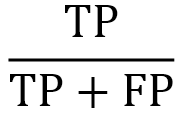
Precision is the percent of selected items that are correct.
1. Which model does better (has the bigger percentage)?
2. Is there a big difference between the two percentages or are they close?
3. What does that tell you?


### Recall
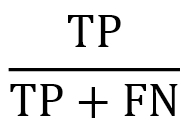
Recall is the percent of correct items that are selected.
1. Which model does better (has the bigger percentage)?
2. Is there a big difference between the two percentages or are they close?
3. What does that tell you?

### Answers

Precision
1.
2.
3.

Recall
1.
2.
3.